# Topic Modeling for News Articles on Coral Bleaching

In [1]:
import os
import re
import string
import sys
from collections import Counter
from itertools import combinations
from glob import glob
from typing import List

import numpy as np
import pandas as pd
import gensim
import matplotlib.pyplot as plt
from contexttimer import Timer
from gensim.corpora.dictionary import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.nmf import Nmf
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import TweetTokenizer, RegexpTokenizer
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, TfidfVectorizer
from sklearn.pipeline import Pipeline

In [2]:
PROJ_ROOT = os.path.join(os.pardir)

## About

### Objective

Experiment with topic coherence using Gensim to find an optimal number of topics from the news listings about global coral bleaching events using cleaned texts that were scraped from the Guardian's news articles.

### Technical Implementation

After the optimal number of topics has been determined by Gensim's NMF, following [previous work](https://github.com/robsalgado/personal_data_science_projects/blob/master/topic_modeling_nmf/topic_modeling_cnn.ipynb), we will use `sklearn`'s `NMF` model with `TFIDF` vectorization to explore the topics, their top N terms and constituent documents (articles).

### Notes

1. See `03_scrape_guardian_articles.ipynb` for scraping code
2. See `04_clean_guardian_articles.ipynb` for data cleaning

## User Inputs

In [3]:
# Contraction map
c_dict = {
    "ain't": "am not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "I would",
    "i'd've": "I would have",
    "i'll": "I will",
    "i'll've": "I will have",
    "i'm": "I am",
    "i've": "I have",
    "isn't": "is not",
    "it'd": "it had",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so is",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there had",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we had",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'alls": "you alls",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you had",
    "you'd've": "you would have",
    "you'll": "you you will",
    "you'll've": "you you will have",
    "you're": "you are",
    "you've": "you have"
}

kmin, kmax = [5, 20+1]

num_top_terms = 10

In [4]:
data_dir = os.path.join(PROJ_ROOT, 'data')
processed_data_dir = os.path.join(data_dir, 'processed')

# filepaths of cleaned and combined articles
fpath_cleaned_combined = os.path.join(
    processed_data_dir, "guardian_articles_cleaned_combined.parquet"
)

# Compiling the contraction dict
c_re = re.compile('(%s)' % '|'.join(c_dict.keys()))

# List of stop words
add_stop = ['said', 'say', '...', 'like', 'cnn', 'ad']
stop_words = ENGLISH_STOP_WORDS.union(add_stop)

# List of punctuation
punc = list(set(string.punctuation))

In [5]:
def get_top_terms_weights_per_topic(H, terms, topic_index, num_top_terms):
    """get the top terms and their weights."""
    top_indices = np.argsort(H[topic_index,:])[::-1]
    top_terms = []
    top_weights = []
    for term_index in top_indices[0:num_top_terms]:
        top_terms.append(terms[term_index])
        top_weights.append(H[topic_index,term_index])
    df_top_terms_weights = (
        pd.DataFrame(
            zip(*[top_terms, top_weights]),
            columns=['terms', 'weights'],
        )
        .assign(topic_num=topic_index+1)
    )
    return df_top_terms_weights


def get_top_words_per_topic(row, n_top_words=10):
    """Get N top words in each topic."""
    return row.nlargest(n_top_words).index.tolist()


# Splits words on white spaces (leaves contractions intact) and splits out
# trailing punctuation
def casual_tokenizer(text):
    tokenizer = TweetTokenizer()
    tokens = tokenizer.tokenize(text)
    return tokens


def expandContractions(text, c_re=c_re):
    def replace(match):
        return c_dict[match.group(0)]
    return c_re.sub(replace, text)


def process_text(text):
    text = casual_tokenizer(text)
    text = [each.lower() for each in text]
    text = [re.sub('[0-9]+', '', each) for each in text]
    text = [expandContractions(each, c_re=c_re) for each in text]
    text = [SnowballStemmer('english').stem(each) for each in text]
    text = [w for w in text if w not in punc]
    text = [w for w in text if w not in stop_words]
    text = [each for each in text if len(each) > 1]
    text = [each for each in text if ' ' not in each]
    return text


def whitespace_tokenizer(text): 
    pattern = r"(?u)\b\w\w+\b" 
    tokenizer_regex = RegexpTokenizer(pattern)
    tokens = tokenizer_regex.tokenize(text)
    return tokens

## Load Data

In [6]:
df = pd.read_parquet(fpath_cleaned_combined)

Extract cleaned texts

In [7]:
raw_documents = df['text_cleaned']

## Pre-Process Text Data

Now, we'll perform the following processing actions on each news article's text

1. [tokenize](https://en.wikipedia.org/wiki/Lexical_analysis#Tokenization) the text of the article, using the `NLTK package's TweetTokenizer`(https://www.nltk.org/api/nltk.tokenize.html#module-nltk.tokenize.casual)
2. clean the text of the articles
   - convert to lowercase
   - remove numbers
   - [expand contractions](https://www.kdnuggets.com/2018/08/practitioners-guide-processing-understanding-text-2.html) ([code](https://grammar.yourdictionary.com/style-and-usage/using-contractions.html))
   - ([snowball](https://en.wikipedia.org/wiki/Snowball_(programming_language))) [stemming](https://en.wikipedia.org/wiki/Stemming)
   - remove [punctuation](https://docs.python.org/3/library/string.html#string.punctuation)
   - remove [stopwords](https://en.wikipedia.org/wiki/Stop_word)
   - remove any standalone single character
   - remove [whitespaces](https://en.wikipedia.org/wiki/Whitespace_character)

In [8]:
%%time
proc_documents = raw_documents.apply(process_text)

CPU times: user 3.4 s, sys: 5.52 ms, total: 3.41 s
Wall time: 3.41 s


### Use Gensim to perform Bag-of-Words transformation

Now, we'll create a corpus comprising an assigned ID and corresponding count frequency of words from the tokens created above. This is Gensim's document conversion into a [bag-of-words](https://en.wikipedia.org/wiki/Bag-of-words_model) format. It returns a list of tuples comprising token identifier and the corresponding count (frequency).

In [9]:
%%time
dictionary = Dictionary(pd.Series(proc_documents))

CPU times: user 74 ms, sys: 16 μs, total: 74.1 ms
Wall time: 73.4 ms


Filter out extremes to limit the number of features

In [10]:
dictionary.filter_extremes(
    # keep tokens contained in at least this many documents
    no_below=3,
    # keep tokens contained in no more than this fraction of documents
    no_above=0.85,
    # keep the N most frequently occuring tokens
    keep_n=5000,
)

Create the bag-of-words format (list of (`token_id`, `token_count`) combinations, or the term-document frequency) for corpus

In [11]:
%%time
corpus = [dictionary.doc2bow(text) for text in proc_documents]

CPU times: user 46.6 ms, sys: 111 μs, total: 46.7 ms
Wall time: 46.4 ms


## Use NMF and Topic Coherence to Get the Optimal Number of Topics

We'll compute the coherence score for our specified list of number of topics to be compared. A [topic coherence](https://radimrehurek.com/gensim/models/coherencemodel.html) `Class`, from the [`Gensim library`](https://pypi.org/project/gensim/), is used to evaluate topics found using an [`NMF`](https://en.wikipedia.org/wiki/Non-negative_matrix_factorization) model.

Create a list of the topic numbers to be tried

In [12]:
topic_nums = list(np.arange(kmin, kmax+1))

Next, we'll use [Gensim's `CoherenceModel`](https://tedboy.github.io/nlps/generated/generated/gensim.models.CoherenceModel.html#gensim-models-coherencemodel) to score the `NMF` approximations of the processed texts using the [topic coherence](https://stats.stackexchange.com/questions/406216/what-is-the-formula-for-c-v-coherence) metric. The coherence model's reported coherence score will be computed as the number of topics used to train an `NMF` model is varied. The higher the coherence for the selected number of topics the better. This way, we can select the number of topics in an NMF model that returns the highest coherence score.

Run the `NMF` model and calculate the coherence score of the specified number of topics

In [13]:
%%time
coherence_scores = []
for num in topic_nums:
    with Timer() as t:
        # define Gensim's NMF model
        nmf = Nmf(
            corpus=corpus,
            num_topics=num,
            id2word=dictionary,
            chunksize=2000,
            passes=5,
            kappa=.1,
            minimum_probability=0.01,
            w_max_iter=300,
            w_stop_condition=0.0001,
            h_max_iter=100,
            h_stop_condition=0.001,
            eval_every=10,
            normalize=True,
            random_state=42
        )
        # Run the coherence model to get the coherence score
        cm = CoherenceModel(
            model=nmf,
            texts=proc_documents,
            dictionary=dictionary,
            coherence='c_v'
        )
        # get the topic coherence score
        coh_score = cm.get_coherence()
    print(f"{num}: {coh_score:.4f} in {t.elapsed:.2f}s")
    coherence_scores.append(coh_score)

5: 0.4445 in 1.48s
6: 0.4582 in 1.63s
7: 0.4812 in 1.71s
8: 0.4629 in 1.90s
9: 0.4445 in 2.18s
10: 0.4740 in 2.43s
11: 0.4523 in 2.43s
12: 0.4677 in 2.51s
13: 0.4599 in 2.69s
14: 0.4388 in 3.90s
15: 0.4677 in 3.69s
16: 0.4705 in 3.50s
17: 0.4328 in 2.69s
18: 0.4355 in 3.06s
19: 0.4444 in 2.95s
20: 0.4532 in 3.17s
21: 0.4403 in 3.43s
CPU times: user 43.6 s, sys: 2min 23s, total: 3min 7s
Wall time: 45.4 s


Store the coherence scores in a `DataFrame`

In [14]:
df_coherences = pd.DataFrame(
    zip(*[coherence_scores, range(kmin, kmax+1)]),
    columns=['coherence_score', 'num_topics']
)

Plot the coherence scores for each number of topics that was tried above

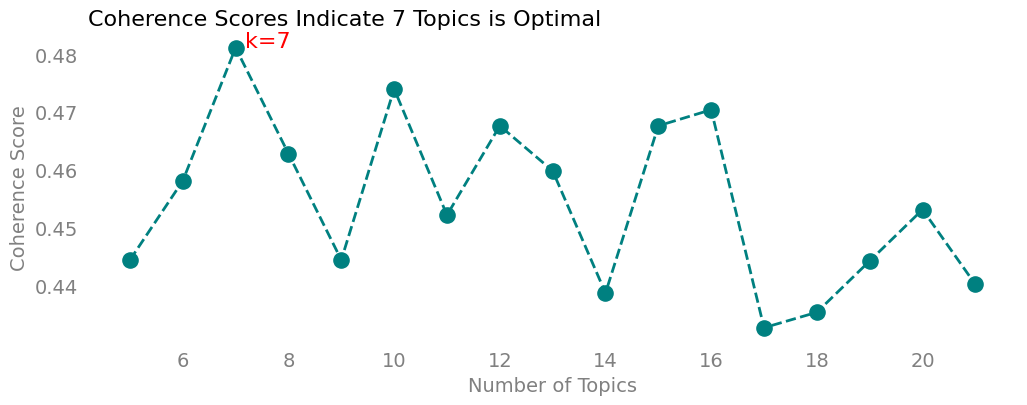

In [15]:
fig, ax = plt.subplots(figsize=(12, 4))
# create scatter plot
_ = df_coherences.plot(
    x='num_topics',
    y='coherence_score',
    kind='scatter',
    s=120,
    c='teal',
    grid=False,
    legend=False,
    ax=ax,
)
# create line plot
_ = df_coherences.plot.line(
    x='num_topics',
    y='coherence_score',
    ax=ax,
    c='teal',
    lw=2,
    legend=False,
    style='--',
)
# get max score
ymax = max(coherence_scores)
xpos = coherence_scores.index(ymax)
# get number of topics with max score
best_k = topic_nums[xpos]
_ = plt.annotate(
    text=f"k={best_k}",
    xy=(best_k, ymax),
    xytext=(best_k, ymax),
    textcoords="offset points",
    fontsize=16,
    color='red',
)
# formatting
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', colors='grey')
# x-axis label
_ = ax.set_xlabel('Number of Topics', fontsize=14, color='grey')
# y-axis label
_ = ax.set_ylabel('Coherence Score', fontsize=14, color='grey')
# title
_ = ax.set_title(
    f"Coherence Scores Indicate {best_k} Topics is Optimal",
    loc='left',
    fontsize=16,
)

**Observations**

1. This plot suggests that the optimal number of topics is 7.

We can also extract the optimal number of topics using the `DataFrame`

In [16]:
k_best = df_coherences.nlargest(1, 'coherence_score')['num_topics'].squeeze()
print(f"The best number of topics is {k_best}")

The best number of topics is 7


**Notes**

1. Although the optimal number of topics can be determined programmatically from the `DataFrame`, it is useful to plot the coherence scores in order to check for other candidates that are close or tied. Here, the manual approach from the `DataFrame` and the value from the chart agree so we will use 7 topics.

## NMF with Optimal Number of Topics

### Train TFIDF-NMF `Pipeline`

In [17]:
def train_nmf_with_best_num_topics(
    k: int, texts: pd.Series
) -> List[np.array]:
    """."""
    vectorizer = TfidfVectorizer(
        tokenizer=None,  # default is None
        stop_words=None,  # default is None
        lowercase=True,  # default is True
        ngram_range=(1, 2),  # default is (1, 2)
        max_df=0.85,  # default is 1.0
        min_df=3,  # default is 1
        max_features=5000,  # default is None
        preprocessor=" ".join,  # default is None
        binary=False,  # default is False
        strip_accents=None,  # default is None
        # token_pattern='(?u)\\b\\w\\w+\\b',  # default is '(?u)\\b\\w\\w+\\b'
    )
    sk_nmf = NMF(
        n_components=k,
        solver="cd",  # default is "cd"
        init="nndsvd",  # default is None, "nnsvd" = Nonnegative Double Singular Value Decomposition
        max_iter=500,  # default is 200
        l1_ratio=0.0,  # default is 0.0
        alpha_W=0.0,  # default is 0.0
        tol=0.0001,  # default is 0.0001
        random_state=42,
    )
    pipe = Pipeline([("vectorizer", vectorizer), ("nmf", sk_nmf)])

    # get document-term matrix
    # # doc_topic = pipe.fit_transform(texts)
    _ = pipe.fit(texts)
    A = pipe.named_steps["vectorizer"].transform(texts)

    # get the factorization matrix, which give the document membership
    # weights relative to each of the k topics
    W = pipe.named_steps["nmf"].components_

    # get the term weights relative to each of the k topics
    H = pipe.named_steps["nmf"].transform(A)

    # Get row-wise (topic-wise) weights
    topic_words_weights = pd.DataFrame(
        W,
        index=[str(k) for k in range(k)],
        columns=pipe.named_steps["vectorizer"].get_feature_names_out(),
    )
    return [A, H, W, topic_words_weights]

Train NLP pipeline with the best number of topics determined above

In [18]:
%%time
A, H, W, topic_words_weights = train_nmf_with_best_num_topics(
    k_best, proc_documents
)

CPU times: user 1.59 s, sys: 1.31 s, total: 2.9 s
Wall time: 756 ms


### Get Trained Model Outputs

Get top 10 weights by topic

In [19]:
df_topic_words = (
    pd.DataFrame(
        topic_words_weights.apply(
            lambda x: get_top_words_per_topic(x, num_top_terms), axis=1
        ).tolist(),
        index=topic_words_weights.index,
    )
    .reset_index()
    .rename(columns={"index": "topic"})
    .assign(topic_num=range(k_best))
).astype({"topic": int})
df_topic_words

,topic,0,1,2,3,4,5,6,7,8,9,topic_num
0,0,fish,sea,ocean,plastic,protect,island,photograph,speci,area,deep,0
1,1,unesco,world heritag,list,heritag,committe,danger,australia,govern,recommend,world,1
2,2,bleach,event,stress,heat,bleach event,barrier reef,great barrier,survey,coral bleach,heat stress,2
3,3,ocean,heat,temperatur,warm,climat,heatwav,record,newslett,sea,global,3
4,4,qualiti,water qualiti,govern,regul,farmer,scienc,report,barrier reef,great barrier,barrier,4
5,5,shark,reef shark,fish,studi,egg,speci,egg case,number,rummer,ray,5
6,6,studi,barrier reef,barrier,great barrier,great,coral reef,climat,larva,cloud,research,6


**Notes**

1. The output has one row per topic.
2. The numeric column names correspond to the topic indices.

Convert document-topic matrix into DataFrame and append url column, to get the most popular topic (highest topic weight) per document

In [20]:
df_doc_topic = (
    pd.DataFrame(H)
    .idxmax(axis=1)
    .rename("topic_num")
    .to_frame()
    .assign(url=df["url"].tolist())
    .astype({"topic_num": pd.Int64Dtype()})
)
with pd.option_context('display.max_columns', None):
    display(
        pd.concat(
            [df_doc_topic.head(1), df_doc_topic.tail(1)]
        )
    )

,topic_num,url
0,3,https://www.theguardian.com/environment/climat...
260,6,https://www.theguardian.com/environment/2024/o...


Merge the document-topic `DataFrame` with top 10 terms by topic to get the most popular topic and top 10 terms for each document

In [21]:
df_doc_topic_words = (
    df_doc_topic
    .merge(df_topic_words, on="topic_num", how="left")
    .astype({"topic_num": pd.Int64Dtype()})
)
with pd.option_context('display.max_columns', None):
    display(
        pd.concat(
            [df_doc_topic_words.head(1), df_doc_topic_words.tail(1)]
        )
    )

,topic_num,url,topic,0,1,2,3,4,5,6,7,8,9
0,3,https://www.theguardian.com/environment/climat...,3,ocean,heat,temperatur,warm,climat,heatwav,record,newslett,sea,global
260,6,https://www.theguardian.com/environment/2024/o...,6,studi,barrier reef,barrier,great barrier,great,coral reef,climat,larva,cloud,research


Calculate residual for each document. This is the difference between the true text and the NMF approximations. Here, we'll use the [Frobenius Norm](https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html#numpy.linalg.norm) to examine how well the topics found represent the news article text - this will be a residual between the modeled and true document-term matrix.

This residual is calculated below

In [22]:
r = np.zeros(A.shape[0])
for row in range(A.shape[0]):
    r[row] = np.linalg.norm(A[row, :] - H[row, :].dot(W), "fro")
# data_doc_topic_words["topic_num_resid"] = r

Merge raw data (`df`) with the document-topic `DataFrame` containing top 10 terms (`df_doc_topic_words`) and append the above residual column

In [23]:
data_doc_topic_words = (
    df
    .merge(df_doc_topic_words, on=["url"], how="left")
    .astype({"topic_num": int})
    .rename(columns={c: f"term_{c}" for c in range(0, 10 + 1)})
    .assign(topic_num_resid=r)
)
with pd.option_context('display.max_columns', None):
    display(
        pd.concat(
            [data_doc_topic_words.head(1), data_doc_topic_words.tail(1)]
        )
    )

,url_num,url_name,url,text,char_count,sentence_count_raw,token_count,text_cleaned,type,webPublicationDate,year,webTitle,page,topic_num,topic,term_0,term_1,term_2,term_3,term_4,term_5,term_6,term_7,term_8,term_9,topic_num_resid
0,1,None,https://www.theguardian.com/environment/climat...,"Last year was the hottest ever measured, conti...",3128,514,782,last year was the hottest ever measured contin...,news_article,2019-01-16 11:00:19+00:00,2019,Our oceans broke heat records in 2018 and the ...,1,3,3,ocean,heat,temperatur,warm,climat,heatwav,record,newslett,sea,global,0.859453
260,21,None,https://www.theguardian.com/environment/2024/o...,Instead of an existential crisis for species w...,7531,1187,1883,instead of an existential crisis for species w...,news_article,2024-10-23 14:00:42+00:00,2024,Bill Maher puts the fate of the Great Barrier ...,70,6,6,studi,barrier reef,barrier,great barrier,great,coral reef,climat,larva,cloud,research,0.870639


Get top 10 terms and their weights per topic

In [24]:
df_topic_word_weights_top_ten = (
    (
        topic_words_weights
        .groupby(topic_words_weights.index)
        .apply(lambda x: x.iloc[0].nlargest(num_top_terms))
        .reset_index()
        .rename(
            columns={"level_0": "topic_num", "level_1": "term", 0: "weight"}
        )
    )
    .astype({"topic_num": int})
    .sort_values(by=["topic_num"])
)
df_topic_word_weights_top_ten

,topic_num,term,weight
0,0,fish,0.568719
1,0,sea,0.488011
2,0,ocean,0.453036
3,0,plastic,0.341840
4,0,protect,0.286801
...,...,...,...
64,6,great,0.204148
65,6,coral reef,0.185955
66,6,climat,0.185765
67,6,larva,0.183259


Pivot the above output from tidy data to untidy data, to get the term weights per topic

In [25]:
df_word_weights = (
    pd.DataFrame(
        (
            df_topic_word_weights_top_ten
            .groupby("topic_num")
            ["weight"]
            .apply(list)
            .tolist()
        ),
        columns=[f"term_{w}_weight" for w in range(0, 9 + 1)],
    )
    .reset_index()
    .rename(columns={"index": "topic_num"})
    .astype({"topic_num": int})
)
df_word_weights

,topic_num,term_0_weight,term_1_weight,term_2_weight,term_3_weight,term_4_weight,term_5_weight,term_6_weight,term_7_weight,term_8_weight,term_9_weight
0,0,0.568719,0.488011,0.453036,0.341840,0.286801,0.240049,0.232575,0.214276,0.210008,0.209476
1,1,0.288911,0.303781,0.320053,0.335521,0.316546,0.400498,0.403290,0.408372,0.443662,0.364468
2,2,0.212738,0.213198,0.213394,0.214116,0.215296,0.216493,0.220976,0.268269,0.839142,0.216703
3,3,0.192084,0.163982,0.166907,0.185875,0.216960,0.237724,0.240776,0.313417,0.327990,0.468881
4,4,0.193001,0.193192,0.196054,0.196448,0.199147,0.237542,0.255245,0.281145,0.299211,0.228056
5,5,0.096736,0.074308,0.088798,0.089933,0.117203,0.136915,0.131745,0.156965,1.223388,0.119726
6,6,0.180724,0.240067,0.212199,0.210676,0.204385,0.204148,0.185955,0.185765,0.183259,0.178643


**Notes**

1. The output has one row per topic.
2. The columns correspond to the 10 term weights for each topic.

Add the above pivotted term weights to merged `DataFrame` with the document topic, top ten terms and residuals (`data_doc_topic_words`)

In [26]:
data_doc_topic_words_weights = (
    data_doc_topic_words
    .merge(df_word_weights, on="topic_num", how="left")
)
with pd.option_context('display.max_columns', None):
    display(
        pd.concat(
            [
                data_doc_topic_words_weights.head(1),
                data_doc_topic_words_weights.tail(1),
            ]
        )
    )

,url_num,url_name,url,text,char_count,sentence_count_raw,token_count,text_cleaned,type,webPublicationDate,year,webTitle,page,topic_num,topic,term_0,term_1,term_2,term_3,term_4,term_5,term_6,term_7,term_8,term_9,topic_num_resid,term_0_weight,term_1_weight,term_2_weight,term_3_weight,term_4_weight,term_5_weight,term_6_weight,term_7_weight,term_8_weight,term_9_weight
0,1,None,https://www.theguardian.com/environment/climat...,"Last year was the hottest ever measured, conti...",3128,514,782,last year was the hottest ever measured contin...,news_article,2019-01-16 11:00:19+00:00,2019,Our oceans broke heat records in 2018 and the ...,1,3,3,ocean,heat,temperatur,warm,climat,heatwav,record,newslett,sea,global,0.859453,0.192084,0.163982,0.166907,0.185875,0.216960,0.237724,0.240776,0.313417,0.327990,0.468881
260,21,None,https://www.theguardian.com/environment/2024/o...,Instead of an existential crisis for species w...,7531,1187,1883,instead of an existential crisis for species w...,news_article,2024-10-23 14:00:42+00:00,2024,Bill Maher puts the fate of the Great Barrier ...,70,6,6,studi,barrier reef,barrier,great barrier,great,coral reef,climat,larva,cloud,research,0.870639,0.180724,0.240067,0.212199,0.210676,0.204385,0.204148,0.185955,0.185765,0.183259,0.178643


### Perform Sanity Checks on Outputs

Verify that `DataFrame` of all term weights contains the correct number of topics

In [27]:
assert len(topic_words_weights) == k_best

heck that the first row of the `DataFrame` with the top `n` words per topic gives the specified number of words

In [28]:
expectd = df_topic_words.iloc[0, 1:-1].tolist()
top_ten_words = topic_words_weights.iloc[0].nlargest(num_top_terms).index.tolist()
assert top_ten_words == expectd

Verify that the URL column in the `DataFrame` with processed news article URL and associated topic number matches the URL from the processed data

In [29]:
assert df_doc_topic["url"].tolist() == df["url"].tolist()

From the `DataFrame` with the terms, term weights and processed data columns (URL, text, publication date, etc.), verify that merging has been performed correctly by checking the following

1. all URLs in the URL column match the URLs column from the processed data
2. the dates are monotically increasing (as is the case with the processed data)

Verification 1 - Checking the full URL column

In [30]:
urls_from_data = data_doc_topic_words_weights["url"].tolist()
assert urls_from_data == df["url"].tolist()

Verification 2 - Checking the date column

In [31]:
data_pubs_dates = data_doc_topic_words_weights["webPublicationDate"].dt.date
assert pd.to_datetime(data_pubs_dates).is_monotonic_increasing

### Plot Topic Residuals

We'll show a boxplot of these topic residuals

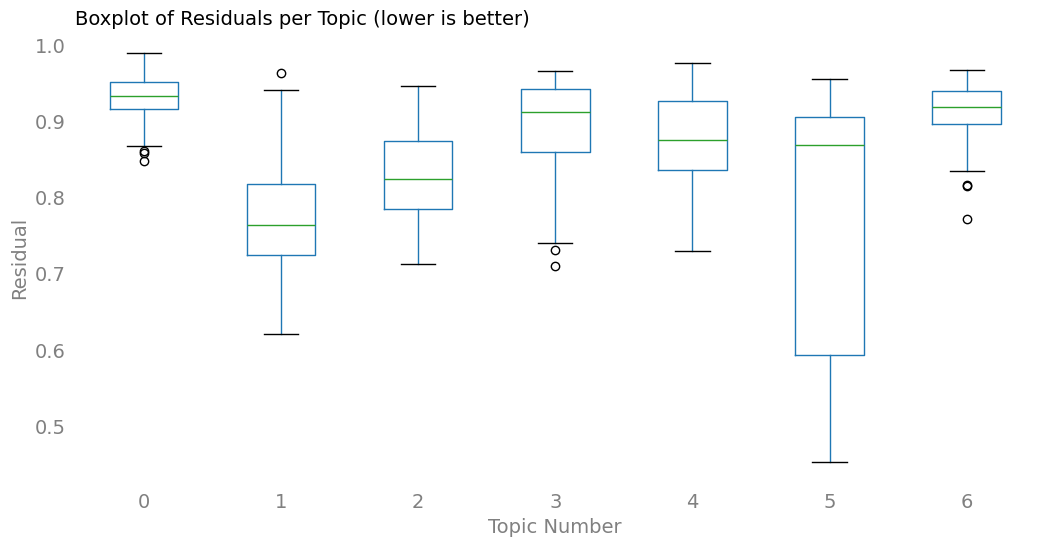

In [32]:
fig, ax = plt.subplots(figsize=(12, 6))
_ = data_doc_topic_words[['topic_num', 'topic_num_resid']].boxplot(
    by='topic_num',
    grid=False,
    ax=ax,
)
# remove plot title
ax.set_title('')
# remove name of grouping column
fig.suptitle('')
# formatting
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', colors='grey')
# x-axis label
_ = ax.set_xlabel('Topic Number', fontsize=14, color='grey')
# y-axis label
_ = ax.set_ylabel('Residual', fontsize=14, color='grey')
# title
_ = ax.set_title(
    "Boxplot of Residuals per Topic (lower is better)",
    loc='left',
    fontsize=14,
)

**Notes**

1. This plot summarizes how the texts in each topic actually fit into that topic. A smaller value on the vertical axis (the residual) indicates a better fit between the news articles in this topic found by the NMF model. Outliers are shown by circles.

**Observations**

1. Only one of the topics has a median residual below 0.80. The `NMF` hyperparameters were hard-coded during topic optimization. Tuning these hyper-parameters and collecting (scraping) more data could be tried to help reduce the median topic residuals.

### Assign Topic Names - Read Texts in Each Topic

In order to assign names to topics, it is necessary to read the best documents (those with the smallest residual) per topic and assess the top terms (highest weight) per topic. This section lists the top 5 URLs per topic for reading and then assigning a topic name

#### Topic 0

In [50]:
(
    df_topic_word_weights_top_ten
    .query("topic_num == 0")
    .reset_index(drop=True)
    .nlargest(10, 'weight')
    [['term', 'weight']]
)

,term,weight
0,fish,0.568719
1,sea,0.488011
2,ocean,0.453036
3,plastic,0.341840
4,protect,0.286801
5,island,0.240049
6,photograph,0.232575
7,speci,0.214276
8,area,0.210008
9,deep,0.209476


The five best texts that fit into topic 0 are shown below

In [33]:
(
    data_doc_topic_words
    .query("topic_num == 0")
    .nsmallest(5, "topic_num_resid")["url"].tolist()
)

['https://www.theguardian.com/environment/2020/jun/11/i-raised-hell-how-people-worldwide-answered-the-call-of-world-oceans-day',
 'https://www.theguardian.com/environment/article/2024/jun/06/how-to-save-oceans-rewilding-conservation-fisheries-pollution-forever-chemicals-deep-sea-mining',
 'https://www.theguardian.com/environment/article/2024/jun/30/neuston-sea-creatures-ocean-surface-science-study',
 'https://www.theguardian.com/environment/2022/may/30/the-ocean-is-everything-pacific-state-of-niue-declares-all-of-its-waters-protected',
 'https://www.theguardian.com/environment/2020/apr/01/oceans-can-be-restored-to-former-glory-within-30-years-say-scientists']

**Observations**

1. The topics of these articles are listed below
   - [readers' efforts to defend occeans on World Oceans Day, such as re-growing corals and setting up land-based coral nurseries](https://www.theguardian.com/environment/2020/jun/11/i-raised-hell-how-people-worldwide-answered-the-call-of-world-oceans-day)
   - [five ways to conserve the oceans and protect corals](https://www.theguardian.com/environment/article/2024/jun/06/how-to-save-oceans-rewilding-conservation-fisheries-pollution-forever-chemicals-deep-sea-mining)
   - [how the *neuston* organisms help coral reefs](https://www.theguardian.com/environment/article/2024/jun/30/neuston-sea-creatures-ocean-surface-science-study)
   - [plans by Pacific island of Niue to protect all of its corals](https://www.theguardian.com/environment/2022/may/30/the-ocean-is-everything-pacific-state-of-niue-declares-all-of-its-waters-protected)
   - [how oceans can be restored](https://www.theguardian.com/environment/2020/apr/01/oceans-can-be-restored-to-former-glory-within-30-years-say-scientists)

**Topic Name**: Ocean **conservation activities to protect and restore corals**

#### Topic 1

In [49]:
(
    df_topic_word_weights_top_ten
    .query("topic_num == 1")
    .reset_index(drop=True)
    .nlargest(10, 'weight')
    [['term', 'weight']]
)

,term,weight
0,fish,0.568719
1,sea,0.488011
2,ocean,0.453036
3,plastic,0.341840
4,protect,0.286801
5,island,0.240049
6,photograph,0.232575
7,speci,0.214276
8,area,0.210008
9,deep,0.209476


The five best texts that fit into topic 1 are shown below

In [34]:
(
    data_doc_topic_words
    .query("topic_num == 1")
    .nsmallest(5, "topic_num_resid")["url"].tolist()
)

['https://www.theguardian.com/environment/2021/jun/22/great-barrier-reef-should-be-listed-as-in-danger-unesco-recommends',
 'https://www.theguardian.com/environment/2021/jun/23/political-ploys-and-an-ocean-jewel-whats-behind-the-uns-in-danger-warning-for-the-great-barrier-reef',
 'https://www.theguardian.com/environment/2021/jun/04/un-body-pushed-to-demand-stronger-climate-action-from-australia-to-save-great-barrier-reef',
 'https://www.theguardian.com/environment/2022/nov/29/explainer-great-barrier-reef-flagged-as-in-danger-world-heritage-site-what-does-this-mean',
 'https://www.theguardian.com/environment/2021/jul/07/australia-demands-world-heritage-experts-visit-great-barrier-reef-ahead-of-in-danger-list-decision']

**Observations**

1. [advocate for placing Great Barrier Reef (world's biggest coral reef) on list of heritage sites that are in danger](https://www.theguardian.com/environment/2021/jun/22/great-barrier-reef-should-be-listed-as-in-danger-unesco-recommends)
2. [reasoning behind United Nation's *in-danger* warning for the Great Barrier reef](https://www.theguardian.com/environment/2021/jun/23/political-ploys-and-an-ocean-jewel-whats-behind-the-uns-in-danger-warning-for-the-great-barrier-reef)
3. [United Nations World Heritage Committee pushes for stronger climate reform to save the Great Barrier Reef](https://www.theguardian.com/environment/2021/jun/04/un-body-pushed-to-demand-stronger-climate-action-from-australia-to-save-great-barrier-reef)
4. [UN scientists recommend Great Barrier reef be placed on a list of world heritage sites that are in danger due to global warming](https://www.theguardian.com/environment/2022/nov/29/explainer-great-barrier-reef-flagged-as-in-danger-world-heritage-site-what-does-this-mean)
5. [Request from Australia to visit Great Barrier reef before it is listed as in-danger](https://www.theguardian.com/environment/2021/jul/07/australia-demands-world-heritage-experts-visit-great-barrier-reef-ahead-of-in-danger-list-decision)

**Topic Name**: Scientific recommendation to **place Great Barrier Reef on list of in-danger heritage sites** due to consequences of global warming

#### Topic 2

In [48]:
(
    df_topic_word_weights_top_ten
    .query("topic_num == 2")
    .reset_index(drop=True)
    .nlargest(10, 'weight')
    [['term', 'weight']]
)

,term,weight
8,bleach,0.839142
7,event,0.268269
6,stress,0.220976
9,heat,0.216703
5,bleach event,0.216493
4,barrier reef,0.215296
3,great barrier,0.214116
2,survey,0.213394
1,coral bleach,0.213198
0,heat stress,0.212738


The five best texts that fit into topic 2 are shown below

In [35]:
(
    data_doc_topic_words
    .query("topic_num == 2")
    .nsmallest(5, "topic_num_resid")["url"].tolist()
)

['https://www.theguardian.com/environment/2024/apr/17/great-barrier-reef-extreme-coral-bleaching',
 'https://www.theguardian.com/environment/2020/apr/01/climate-crisis-may-have-pushed-worlds-tropical-coral-reefs-to-tipping-point-of-near-annual-bleaching',
 'https://www.theguardian.com/environment/2020/feb/20/great-barrier-reef-on-brink-of-third-major-coral-bleaching-in-five-years-scientists-warn',
 'https://www.theguardian.com/environment/2024/apr/15/great-barrier-reef-coral-bleaching-global-heating',
 'https://www.theguardian.com/environment/2022/mar/17/great-barrier-reef-hit-by-sixth-mass-bleaching-event-leading-coral-scientist-says']

**Observations**

1. [strong coral bleaching observed at Great Barrier Reef](https://www.theguardian.com/environment/2024/apr/17/great-barrier-reef-extreme-coral-bleaching)
2. [rising ocean temperatures could have pushed coral reefs to experience annual bleaching events](https://www.theguardian.com/environment/2020/apr/01/climate-crisis-may-have-pushed-worlds-tropical-coral-reefs-to-tipping-point-of-near-annual-bleaching)
3. [third major coral bleaching event projected at Great Barrier Reef](https://www.theguardian.com/environment/2020/feb/20/great-barrier-reef-on-brink-of-third-major-coral-bleaching-in-five-years-scientists-warn)
4. [global warming accounts for another mass planet-wide bleaching event](https://www.theguardian.com/environment/2024/apr/15/great-barrier-reef-coral-bleaching-global-heating)
5. [sixth major coral bleaching event projected at Great Barrier Reef](https://www.theguardian.com/environment/2022/mar/17/great-barrier-reef-hit-by-sixth-mass-bleaching-event-leading-coral-scientist-says)

**Topic Name**: **occurrence of major bleaching events at GBR**

#### Topic 3

In [47]:
(
    df_topic_word_weights_top_ten
    .query("topic_num == 3")
    .reset_index(drop=True)
    .nlargest(10, 'weight')
    [['term', 'weight']]
)

,term,weight
9,ocean,0.468881
8,heat,0.327990
7,temperatur,0.313417
6,warm,0.240776
5,climat,0.237724
4,heatwav,0.216960
0,record,0.192084
3,newslett,0.185875
2,sea,0.166907
1,global,0.163982


The five best texts that fit into topic 3 are shown below

In [36]:
(
    data_doc_topic_words
    .query("topic_num == 3")
    .nsmallest(5, "topic_num_resid")["url"].tolist()
)

['https://www.theguardian.com/environment/2023/apr/08/headed-off-the-charts-worlds-ocean-surface-temperature-hits-record-high',
 'https://www.theguardian.com/environment/2023/may/15/oceans-have-been-absorbing-the-worlds-extra-heat-but-theres-a-huge-payback',
 'https://www.theguardian.com/environment/2023/aug/04/oceans-hit-highest-ever-recorded-temperature',
 'https://www.theguardian.com/environment/2023/apr/26/accelerating-ocean-warming-earth-temperatures-climate-crisis',
 'https://www.theguardian.com/environment/2022/oct/18/amount-of-ocean-heat-found-to-be-accelerating-and-fuelling-extreme-weather-events']

**Observations**

1. [record ocean temperature observed](https://www.theguardian.com/environment/2023/apr/08/headed-off-the-charts-worlds-ocean-surface-temperature-hits-record-high)
2. [consequences of record ocean temperatures](https://www.theguardian.com/environment/2023/may/15/oceans-have-been-absorbing-the-worlds-extra-heat-but-theres-a-huge-payback)
3. [ocean temperature reaches record and is climbing](https://www.theguardian.com/environment/2023/aug/04/oceans-hit-highest-ever-recorded-temperature)
4. [record ocean temperatures and their consequences](https://www.theguardian.com/environment/2023/apr/26/accelerating-ocean-warming-earth-temperatures-climate-crisis)
5. [ocean heat is accelerating and triggering extreme weather events, that damage coral reefs](https://www.theguardian.com/environment/2022/oct/18/amount-of-ocean-heat-found-to-be-accelerating-and-fuelling-extreme-weather-events)

**Topic Name**: **occurrence of record ocean temperatures that** have potential to **trigger bleaching** events

#### Topic 4

In [46]:
(
    df_topic_word_weights_top_ten
    .query("topic_num == 4")
    .reset_index(drop=True)
    .nlargest(10, 'weight')
    [['term', 'weight']]
)

,term,weight
8,qualiti,0.299211
7,water qualiti,0.281145
6,govern,0.255245
5,regul,0.237542
9,farmer,0.228056
4,scienc,0.199147
3,report,0.196448
2,barrier reef,0.196054
1,great barrier,0.193192
0,barrier,0.193001


The five best texts that fit into topic 4 are shown below

In [37]:
(
    data_doc_topic_words
    .query("topic_num == 4")
    .nsmallest(5, "topic_num_resid")["url"].tolist()
)

['https://www.theguardian.com/environment/2019/sep/19/reef-protection-laws-pass-despite-industry-attacks-on-their-scientific-basis',
 'https://www.theguardian.com/environment/2019/nov/17/queensland-farmers-federation-bosss-denial-of-science-sparks-call-to-suspend-reef-grants',
 'https://www.theguardian.com/environment/2019/nov/26/australias-science-academy-attacks-cherrypicking-of-great-barrier-reef-research',
 'https://www.theguardian.com/environment/2022/feb/13/australia-is-spending-billions-on-the-great-barrier-reef-will-it-do-any-good',
 'https://www.theguardian.com/environment/2020/oct/09/scientists-claim-coalition-misrepresented-their-evidence-to-great-barrier-reef-inquiry']

**Observations**

1. [coral reef protection laws approved in Australia, despite agricultural industry criticizing science behind these laws](https://www.theguardian.com/environment/2019/sep/19/reef-protection-laws-pass-despite-industry-attacks-on-their-scientific-basis)
2. [agricultural industry leader critizes science behind Great Barrier Reef protection and calls to stop reef protection funding](https://www.theguardian.com/environment/2019/nov/17/queensland-farmers-federation-bosss-denial-of-science-sparks-call-to-suspend-reef-grants)
3. [Science institution responds to misrepresentation of scientific evidence by those that deny climate science](https://www.theguardian.com/environment/2019/nov/26/australias-science-academy-attacks-cherrypicking-of-great-barrier-reef-research)
4. [assessment of whether Great Barrier reef funding can offset rising temperatures from climate change](https://www.theguardian.com/environment/2022/feb/13/australia-is-spending-billions-on-the-great-barrier-reef-will-it-do-any-good)
5. [politicians criticize scientists for linking polluted farm water runoff and damage (bleach) to Great Barrier reef](https://www.theguardian.com/environment/2020/oct/09/scientists-claim-coalition-misrepresented-their-evidence-to-great-barrier-reef-inquiry)

**Topic Name**: **opposition to coral reef protection laws by agricultural industry**

#### Topic 5

In [45]:
(
    df_topic_word_weights_top_ten
    .query("topic_num == 5")
    .reset_index(drop=True)
    .nlargest(10, 'weight')
    [['term', 'weight']]
)

,term,weight
8,shark,1.223388
7,reef shark,0.156965
5,fish,0.136915
6,studi,0.131745
9,egg,0.119726
4,speci,0.117203
0,egg case,0.096736
3,number,0.089933
2,rummer,0.088798
1,ray,0.074308


The five best texts that fit into topic 5 are shown below

In [38]:
(
    data_doc_topic_words
    .query("topic_num == 5")
    .nsmallest(5, "topic_num_resid")["url"].tolist()
)

['https://www.theguardian.com/environment/2021/jan/31/will-sharks-survive-scientists-fear-for-oceans-apex-predators-without-more-protection',
 'https://www.theguardian.com/environment/2020/jul/06/why-we-need-sharks-the-true-nature-of-the-oceans-monstrous-villains',
 'https://www.theguardian.com/environment/2020/jul/23/sharks-functionally-extinct-at-20-of-worlds-coral-reefs-as-fishing-drives-global-decline',
 'https://www.theguardian.com/environment/article/2024/sep/09/sharks-deserting-coral-reefs-climate-crisis-heating-oceans-study',
 'https://www.theguardian.com/environment/2021/jan/12/baby-sharks-emerge-from-egg-cases-earlier-and-weaker-in-oceans-warmed-by-climate-crisis']

**Observations**

1. [damaging impact of declining sharks (by increased global fishing) in the open ocean on coral reefs](https://www.theguardian.com/environment/2021/jan/31/will-sharks-survive-scientists-fear-for-oceans-apex-predators-without-more-protection)
2. [how sharks protect coral reefs from being overrun and damaged by small fish and algae](https://www.theguardian.com/environment/2020/jul/06/why-we-need-sharks-the-true-nature-of-the-oceans-monstrous-villains)
3. [decline of sharks globally is adding to damage inflicted by climate change (rising temperatures)](https://www.theguardian.com/environment/2020/jul/23/sharks-functionally-extinct-at-20-of-worlds-coral-reefs-as-fishing-drives-global-decline)
4. [report on scientific study showing how absence of predator (sharks) and bleaching are combining to damage coral reefs](https://www.theguardian.com/environment/article/2024/sep/09/sharks-deserting-coral-reefs-climate-crisis-heating-oceans-study)
5. [baby sharks are weakened by climate change, which impedes their ability to protect coral reefs](https://www.theguardian.com/environment/2021/jan/12/baby-sharks-emerge-from-egg-cases-earlier-and-weaker-in-oceans-warmed-by-climate-crisis)

**Topic Name**: **increased shark hunting compounds coral bleaching due to climate change**

#### Topic 6

In [44]:
(
    df_topic_word_weights_top_ten
    .query("topic_num == 6")
    .reset_index(drop=True)
    .nlargest(10, 'weight')
    [['term', 'weight']]
)

,term,weight
1,studi,0.240067
2,barrier reef,0.212199
3,barrier,0.210676
4,great barrier,0.204385
5,great,0.204148
6,coral reef,0.185955
7,climat,0.185765
8,larva,0.183259
0,cloud,0.180724
9,research,0.178643


The five best texts that fit into topic 6 are shown below

In [39]:
(
    data_doc_topic_words
    .query("topic_num == 6")
    .nsmallest(5, "topic_num_resid")["url"].tolist()
)

['https://www.theguardian.com/environment/2020/apr/18/rebuild-it-shade-it-breed-it-three-tactics-to-buy-time-for-the-great-barrier-reef',
 'https://www.theguardian.com/environment/2021/apr/29/life-support-measures-could-buy-great-barrier-reef-another-two-decades-study-finds',
 'https://www.theguardian.com/environment/2020/apr/16/brightening-clouds-and-coral-larvae-study-picks-best-great-barrier-reef-rescue-ideas',
 'https://www.theguardian.com/environment/2021/nov/26/great-barrier-reef-how-a-spectacular-coral-spawning-event-is-helping-to-breed-heat-tolerant-corals',
 'https://www.theguardian.com/environment/2020/oct/17/why-there-is-hope-that-the-worlds-coral-reefs-can-be-saved']

**Observations**

1. [3 strategies to buy time for Great Barrier Reef (rebuild, shade and breed)](https://www.theguardian.com/environment/2020/apr/18/rebuild-it-shade-it-breed-it-three-tactics-to-buy-time-for-the-great-barrier-reef)
2. [emergency measures recommended to offset coral damage in Great Barrier Reef due to bleaching and extend life by 20 years](https://www.theguardian.com/environment/2021/apr/29/life-support-measures-could-buy-great-barrier-reef-another-two-decades-study-finds)
3. [study selecting best ideas to rescue Great Barrier reef](https://www.theguardian.com/environment/2020/apr/16/brightening-clouds-and-coral-larvae-study-picks-best-great-barrier-reef-rescue-ideas)
4. [how new coral spawning event could counter declining corals due to bleaching events](https://www.theguardian.com/environment/2021/nov/26/great-barrier-reef-how-a-spectacular-coral-spawning-event-is-helping-to-breed-heat-tolerant-corals)
5. [strategies to save coral reefs from consequences of climate change](https://www.theguardian.com/environment/2020/oct/17/why-there-is-hope-that-the-worlds-coral-reefs-can-be-saved)

**Topic Name**: **scientific recommendations to counter impact of bleaching events**

## Conclusions

1. The number of topics in the Guardian's news articles on coral bleaching was determined to be 7, using the topic coherence score metric.
2. The top terms per topic were identified. Using these and by reading news articles within each topic, it was possible to name the topics. Below are the topics in the Guardian's news articles over the last 5 years (since January 2019) that cover coral bleaching
   - Topic 0 - Ocean **conservation activities to protect and restore corals**
   - Topic 1 - Scientific recommendation to **place Great Barrier Reef on list of in-danger heritage sites** due to consequences of global warming
   - Topic 2 - **occurrence of major bleaching events at GBR**
   - Topic 3 - **occurrence of record ocean temperatures that have potential to trigger bleaching events**
   - Topic 4 - **opposition to coral reef protection laws by agricultural industry**
   - Topic 5 - **increased shark hunting compounds coral bleaching due to climate change**
   - Topic 6 - **scientific recommendations to counter impact of bleaching events**
3. All topics except for topics 0 and 5 are directly related to coral bleaching events. Topics 0 and 5 indirectly discuss occurrence of coral bleaching events.

## Summary

Topic modeling has extracted topics that characterize how the scientific community, public and industry addresses the impact of climate change on worldwide coral reefs. While an underlying theme of rising global tempeartures damaging global coral deposits is prevalent, the Guardian has published important stories on activities that compound and seek to offset or delay this damage.